In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/Technology_Usage_Spells.csv")

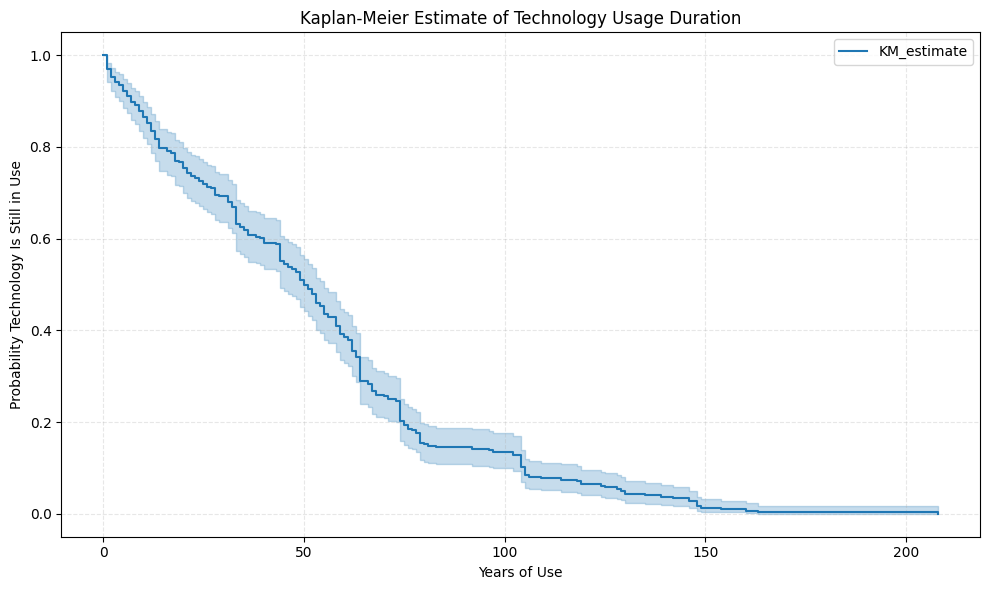

In [5]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df["duration_years"], event_observed=df["event_observed"])

# Plot the survival function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Estimate of Technology Usage Duration")
plt.xlabel("Years of Use")
plt.ylabel("Probability Technology Is Still in Use")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=236af083cdf40f377aebf13cc31ef0f9595588266b8e14af36d38bc473108a7e
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


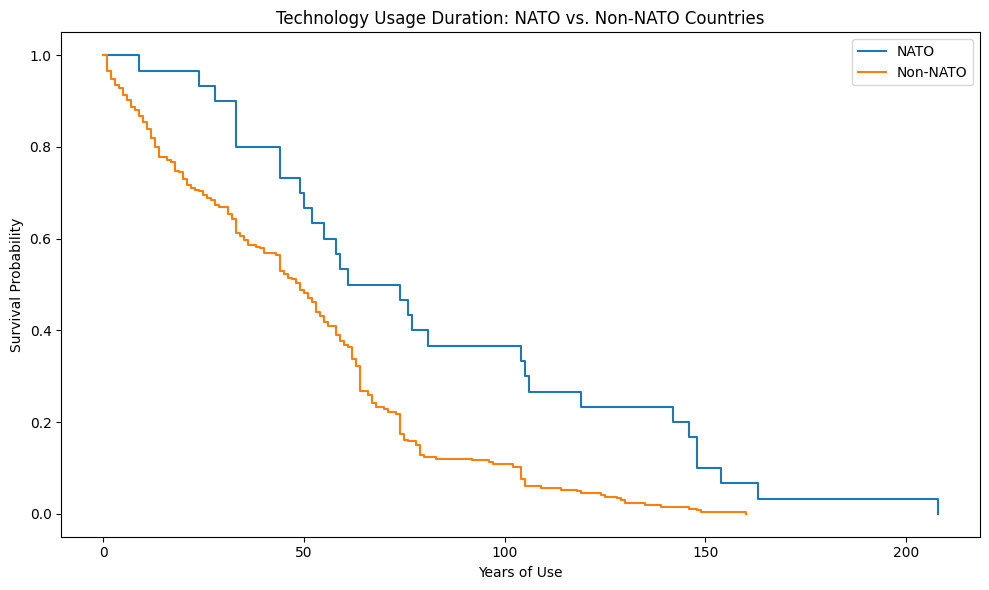

In [6]:
# Start by identifying NATO countries
# NATO founding members and later joiners (using standard COW codes)
nato_ccodes = [
    2, 20, 200, 220, 225, 255, 290, 310, 325, 365, 366, 368, 369, 370, 372, 385, 402, 404,
    410, 420, 421, 423, 775, 840
]

# Add NATO membership as a binary flag
df["nato_member"] = df["ccode"].isin(nato_ccodes).astype(int)

# Now fit and plot separate Kaplan-Meier curves for NATO vs. non-NATO
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

for group_value, group_name in zip([1, 0], ["NATO", "Non-NATO"]):
    subset = df[df["nato_member"] == group_value]
    kmf.fit(subset["duration_years"], subset["event_observed"], label=group_name)
    kmf.plot_survival_function(ci_show=False)

plt.title("Technology Usage Duration: NATO vs. Non-NATO Countries")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
from lifelines.statistics import logrank_test

# Split groups
nato_group = df[df["nato_member"] == 1]
non_nato_group = df[df["nato_member"] == 0]

# Run the log-rank test
result = logrank_test(
    nato_group["duration_years"], non_nato_group["duration_years"],
    event_observed_A=nato_group["event_observed"],
    event_observed_B=non_nato_group["event_observed"]
)

result.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.69 <0.005     14.47

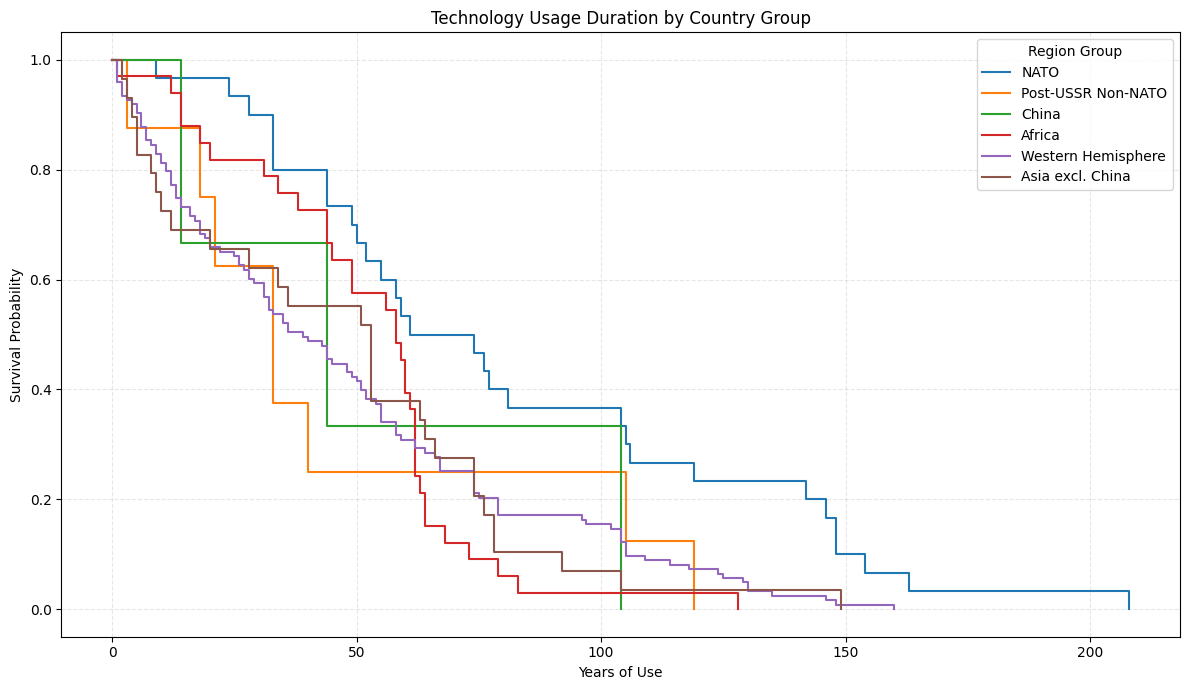

In [10]:
spell_df = pd.read_csv("/content/Technology_Usage_Spells.csv")

# Define country groups by ccode
nato_ccodes = [
    2, 20, 200, 220, 225, 255, 290, 310, 325, 365, 366, 368, 369, 370, 372,
    385, 402, 404, 410, 420, 421, 423, 775, 840
]

ussr_successor_non_nato = [
    365, 364, 369, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 385
]
ussr_successor_non_nato = [cc for cc in ussr_successor_non_nato if cc not in nato_ccodes]

china_ccode = [710]

# COW region codes for continents (approximate grouping based on COW geography)
# Africa: 500–620
africa_ccodes = list(range(500, 621))

# Western Hemisphere (excluding NATO: 2, 20, 840, 100, 200)
western_hemisphere_ccodes = [cc for cc in range(2, 399) if cc not in nato_ccodes]

# Asia (excluding China and NATO)
asia_ccodes = [cc for cc in range(630, 700) if cc not in china_ccode and cc not in nato_ccodes]

# Assign group labels
def assign_group(ccode):
    if ccode in nato_ccodes:
        return "NATO"
    elif ccode in ussr_successor_non_nato:
        return "Post-USSR Non-NATO"
    elif ccode in china_ccode:
        return "China"
    elif ccode in africa_ccodes:
        return "Africa"
    elif ccode in western_hemisphere_ccodes:
        return "Western Hemisphere"
    elif ccode in asia_ccodes:
        return "Asia excl. China"
    else:
        return "Other"

# Apply grouping
spell_df["region_group"] = spell_df["ccode"].apply(assign_group)

# Filter only desired groups
desired_groups = [
    "NATO", "Post-USSR Non-NATO", "China", "Africa", "Western Hemisphere", "Asia excl. China"
]
filtered_df = spell_df[spell_df["region_group"].isin(desired_groups)]

# Plot Kaplan-Meier curves
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

for group in desired_groups:
    subset = filtered_df[filtered_df["region_group"] == group]
    kmf.fit(durations=subset["duration_years"], event_observed=subset["event_observed"], label=group)
    kmf.plot_survival_function(ci_show=False)

plt.title("Technology Usage Duration by Country Group")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Region Group")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
from lifelines.statistics import logrank_test
import itertools
import pandas as pd
import numpy as np

# Get the groups you compared
groups = ["NATO", "Post-USSR Non-NATO", "China", "Africa", "Western Hemisphere", "Asia excl. China"]

# Store results
logrank_results = []

# Loop over all unique group pairs
for g1, g2 in itertools.combinations(groups, 2):
    df1 = spell_df[spell_df["region_group"] == g1]
    df2 = spell_df[spell_df["region_group"] == g2]

    result = logrank_test(
        df1["duration_years"], df2["duration_years"],
        event_observed_A=df1["event_observed"],
        event_observed_B=df2["event_observed"]
    )

    logrank_results.append({
        "Group 1": g1,
        "Group 2": g2,
        "Chi2": result.test_statistic,
        "p-value": result.p_value,
        "-log2(p)": -np.log2(result.p_value) if result.p_value > 0 else float("inf")
    })

# Create a DataFrame of the results
logrank_df = pd.DataFrame(logrank_results).sort_values("p-value")
print(logrank_df)


               Group 1             Group 2       Chi2   p-value   -log2(p)
3                 NATO  Western Hemisphere  13.005101  0.000311  11.652452
2                 NATO              Africa   9.065420  0.002605   8.584563
4                 NATO    Asia excl. China   7.539354  0.006037   7.372056
0                 NATO  Post-USSR Non-NATO   4.466069  0.034574   4.854150
1                 NATO               China   1.501777  0.220398   2.181816
11               China    Asia excl. China   0.225254  0.635065   0.655023
13              Africa    Asia excl. China   0.172282  0.678091   0.560448
9                China              Africa   0.159113  0.689974   0.535386
6   Post-USSR Non-NATO              Africa   0.033579  0.854605   0.226671
8   Post-USSR Non-NATO    Asia excl. China   0.033148  0.855532   0.225107
14  Western Hemisphere    Asia excl. China   0.027535  0.868207   0.203890
7   Post-USSR Non-NATO  Western Hemisphere   0.019193  0.889814   0.168424
5   Post-USSR Non-NATO   

In [13]:
def label_us_period(row):
    if row["ccode"] != 2:  # US only
        return None
    if row["start_year"] < 1916:
        return "1816–1915"
    elif row["start_year"] < 1941:
        return "1916–1940"
    elif row["start_year"] <= 1991:
        return "1945–1991"
    else:
        return "1992+"

spell_df["us_period"] = spell_df.apply(label_us_period, axis=1)


In [14]:
us_spells = spell_df[spell_df["us_period"].notna()].copy()


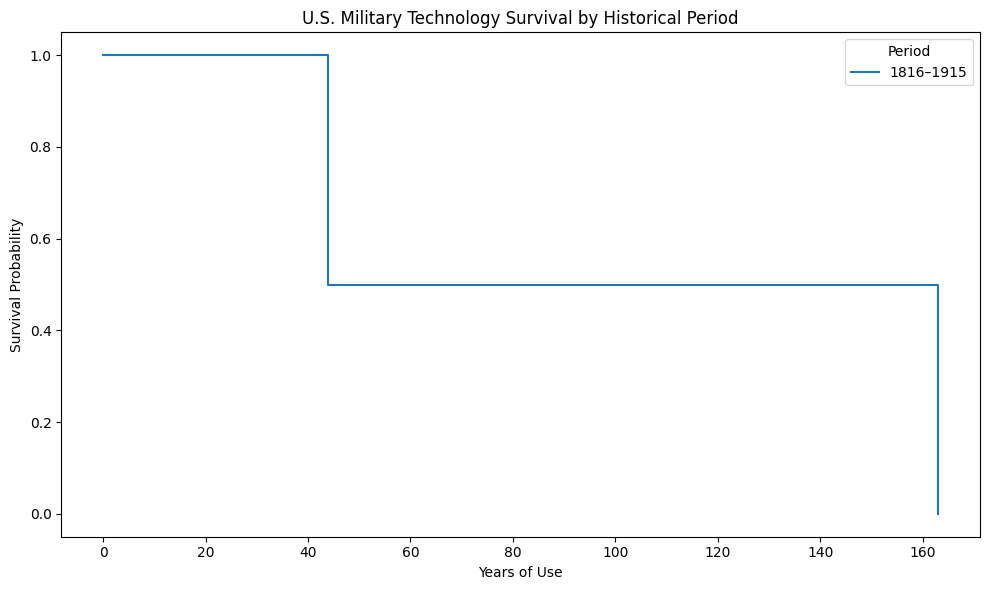

In [15]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for period in us_spells["us_period"].unique():
    subset = us_spells[us_spells["us_period"] == period]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=period)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Period")
plt.tight_layout()
plt.show()


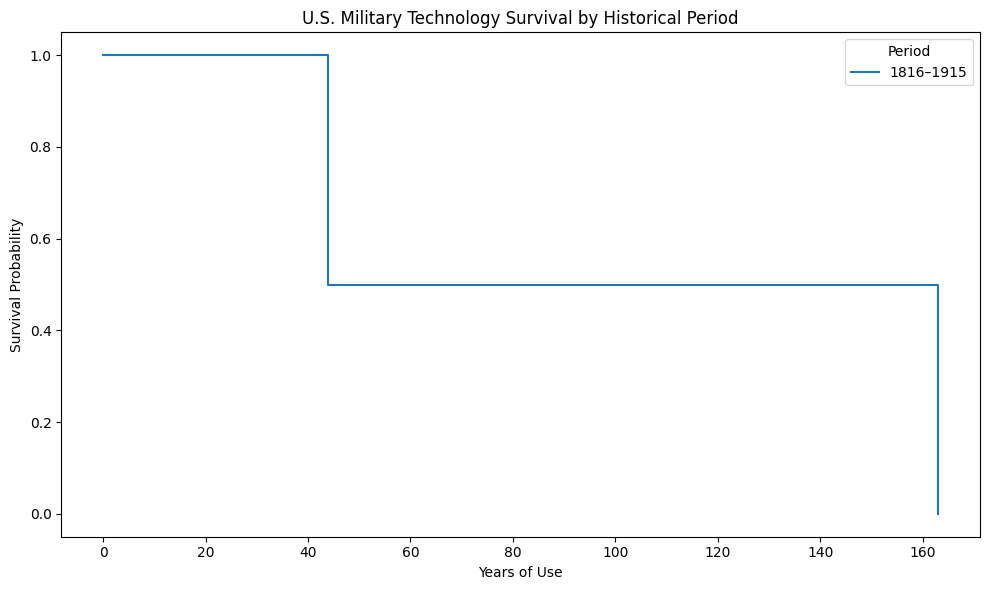

In [16]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for period in us_spells["us_period"].unique():
    subset = us_spells[us_spells["us_period"] == period]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=period)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Period")
plt.tight_layout()
plt.show()


In [17]:
from lifelines.statistics import logrank_test

periods = us_spells["us_period"].unique()
for p1, p2 in itertools.combinations(periods, 2):
    df1 = us_spells[us_spells["us_period"] == p1]
    df2 = us_spells[us_spells["us_period"] == p2]
    result = logrank_test(df1["duration_years"], df2["duration_years"],
                          event_observed_A=df1["event_observed"],
                          event_observed_B=df2["event_observed"])
    print(f"{p1} vs {p2} — p-value: {result.p_value:.4f}, chi²: {result.test_statistic:.2f}")


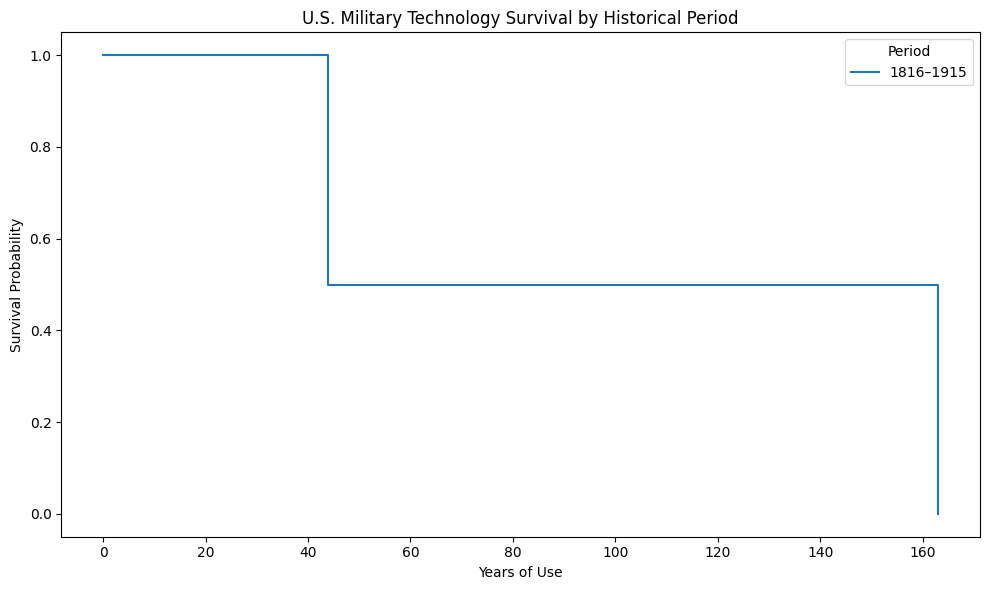

In [20]:
# Re-import libraries after environment reset
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Load previously uploaded file again (if needed)
file_path = 'cow_arms_tech_long.csv'
arms_df = pd.read_csv(file_path)

# Sort and preprocess
arms_df = arms_df.sort_values(["ccode", "techname", "year"])
arms_df["used"] = arms_df["total_use"].notna() & (arms_df["total_use"] > 0)
arms_df["used_shift"] = arms_df.groupby(["ccode", "techname"])["used"].shift(1, fill_value=False)
arms_df["new_period"] = arms_df["used"] & (~arms_df["used_shift"])
arms_df["usage_group"] = arms_df.groupby(["ccode", "techname"])["new_period"].cumsum()
arms_df.loc[~arms_df["used"], "usage_group"] = pd.NA

# Aggregate usage spells
spell_df = arms_df.dropna(subset=["usage_group"]).groupby(["ccode", "techname", "usage_group"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spell_df["duration_years"] = spell_df["end_year"] - spell_df["start_year"] + 1
spell_df["event_observed"] = (spell_df["end_year"] != 2024).astype(int)

# Label periods for US only (ccode == 2)
def label_us_period(row):
    if row["ccode"] != 2:
        return None
    if row["start_year"] < 1916:
        return "1816–1915"
    elif row["start_year"] < 1941:
        return "1916–1940"
    elif row["start_year"] <= 1991:
        return "1945–1991"
    else:
        return "1992+"

spell_df["us_period"] = spell_df.apply(label_us_period, axis=1)
us_spells = spell_df[spell_df["us_period"].notna()].copy()

# Plot Kaplan-Meier curves by historical period
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for period in us_spells["us_period"].unique():
    subset = us_spells[us_spells["us_period"] == period]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=period)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Period")
plt.tight_layout()
plt.show()


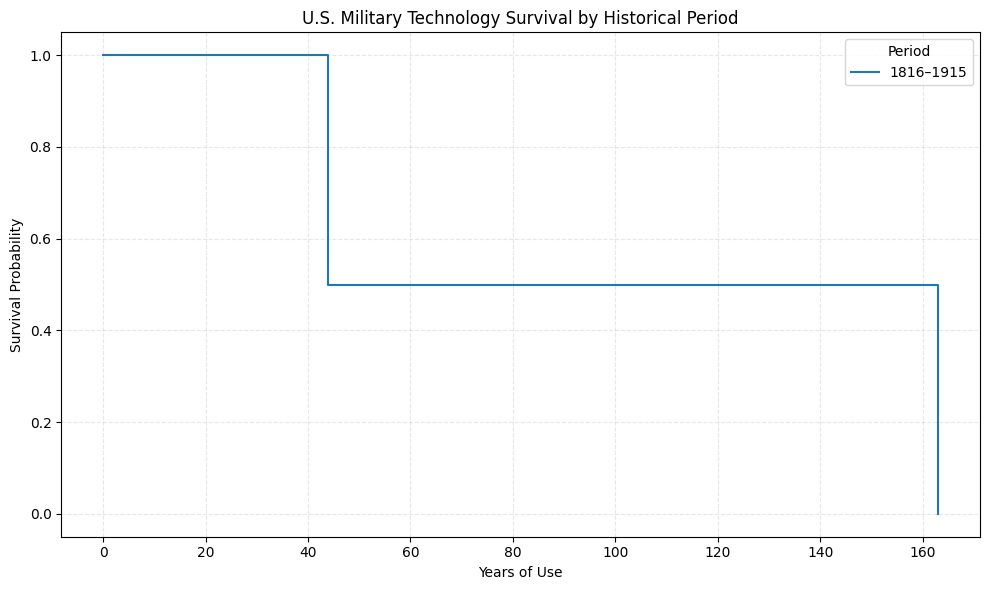

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Load your dataset
df = pd.read_csv("cow_arms_tech_long.csv")

# Preprocess and detect usage spells
df = df.sort_values(["ccode", "techname", "year"])
df["used"] = df["total_use"].notna() & (df["total_use"] > 0)
df["used_shift"] = df.groupby(["ccode", "techname"])["used"].shift(1, fill_value=False)
df["new_period"] = df["used"] & (~df["used_shift"])
df["usage_group"] = df.groupby(["ccode", "techname"])["new_period"].cumsum()
df.loc[~df["used"], "usage_group"] = pd.NA

# Collapse to spells
spell_df = df.dropna(subset=["usage_group"]).groupby(["ccode", "techname", "usage_group"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()
spell_df["duration_years"] = spell_df["end_year"] - spell_df["start_year"] + 1
spell_df["event_observed"] = (spell_df["end_year"] != 2024).astype(int)

# Label U.S. periods
def label_us_period(row):
    if row["ccode"] != 2:
        return None
    if row["start_year"] < 1916:
        return "1816–1915"
    elif row["start_year"] < 1941:
        return "1916–1940"
    elif row["start_year"] <= 1991:
        return "1945–1991"
    else:
        return "1992+"

spell_df["us_period"] = spell_df.apply(label_us_period, axis=1)
us_spells = spell_df[spell_df["us_period"].notna()].copy()

# Plot Kaplan-Meier curves by period
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()
for period in sorted(us_spells["us_period"].unique()):
    subset = us_spells[us_spells["us_period"] == period]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=period)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Period")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
# How many spells per US period?
us_period_counts = spell_df.query("ccode == 2")["start_year"].value_counts()
print(us_period_counts)


start_year
1816    1
1861    1
Name: count, dtype: int64


In [24]:
arms_df["used"] = arms_df["total_use"].notna() & (arms_df["total_use"] > 0)


In [25]:
us_subset = arms_df[arms_df["ccode"] == 2]
us_subset.groupby("techname")["total_use"].nunique().sort_values()


,total_use
techname,
Armed UAV,0
Assault Rifle,0
Attack helicopter,0
Automatic machine gun,0
Breechloading artillery,0
Box magazine rifle,0
Breechloading rifle,0
Early tank,0
First gen. jet fighter,0


In [35]:
# Step 1: Mark technologies as used based on corrected rules
arms_df = pd.read_csv("cow_arms_tech_long.csv")
arms_df = arms_df.sort_values(["ccode", "techname", "year"])

# Define use: 1 = used, 9 = superseded but still used
arms_df["used"] = arms_df["use"].isin([1])

# Detect usage periods
arms_df["used_shift"] = arms_df.groupby(["ccode", "techname"])["used"].shift(1, fill_value=False)
arms_df["new_period"] = arms_df["used"] & (~arms_df["used_shift"])
arms_df["usage_group"] = arms_df.groupby(["ccode", "techname"])["new_period"].cumsum()
arms_df.loc[~arms_df["used"], "usage_group"] = pd.NA

# Step 2: Construct spells (for all countries, not just US)
spell_df = arms_df.dropna(subset=["usage_group"]).groupby(["ccode", "techname", "usage_group"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spell_df["duration_years"] = spell_df["end_year"] - spell_df["start_year"] + 1
spell_df["event_observed"] = (spell_df["end_year"] != 2023).astype(int)  # 0 if censored

# Step 3: Assign historical periods for U.S. entries
def label_us_period(row):
    if row["ccode"] != 2:
        return None
    if row["start_year"] < 1916:
        return "1816–1915"
    elif row["start_year"] < 1941:
        return "1916–1940"
    elif row["start_year"] <= 1991:
        return "1945–1991"
    else:
        return "1992+"

spell_df["us_period"] = spell_df.apply(label_us_period, axis=1)
us_spells = spell_df[spell_df["us_period"].notna()].copy()





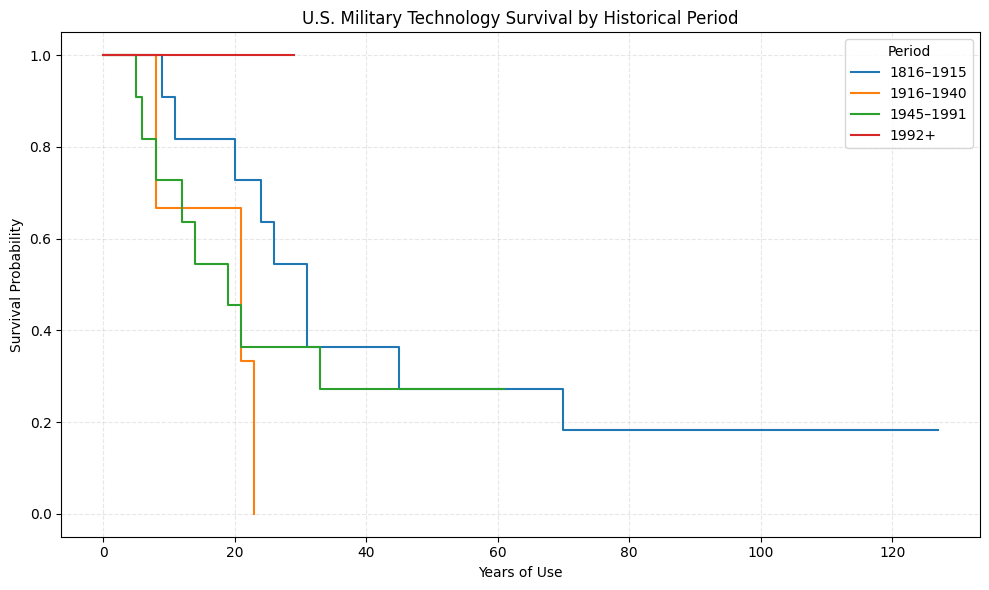

In [36]:
# Proceed with Kaplan-Meier plot comparing U.S. historical periods
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for period in sorted(us_spells["us_period"].unique()):
    subset = us_spells[us_spells["us_period"] == period]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=period)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Period")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [29]:
# Create a lookup for (ccode, techname, usage_group) ending in 2023 and still marked "used" in 2023
active_2023 = arms_df[(arms_df["year"] == 2023) & arms_df["used"]][["ccode", "techname", "usage_group"]]
active_2023["still_used_2023"] = True

# Merge this flag into spell_df
spell_df = spell_df.merge(active_2023, on=["ccode", "techname", "usage_group"], how="left")
spell_df["still_used_2023"] = spell_df["still_used_2023"].fillna(False)

# Now define the event
spell_df["event_observed"] = ~spell_df["still_used_2023"]
spell_df["event_observed"] = spell_df["event_observed"].astype(int)


<ipython-input-29-fcfe8e5db883>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spell_df["still_used_2023"] = spell_df["still_used_2023"].fillna(False)


<ipython-input-32-d98abc42350f>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spell_df["still_used_2023"] = spell_df["still_used_2023"].fillna(False)


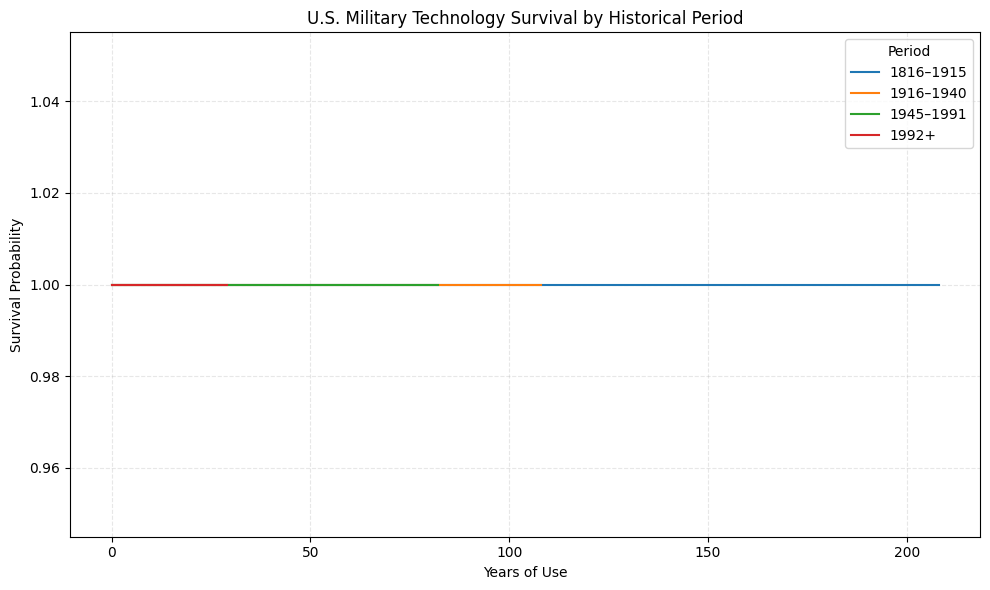

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Recalculate correct censoring logic
active_2023 = arms_df[(arms_df["year"] == 2023) & (arms_df["used"])][["ccode", "techname", "usage_group"]]
active_2023["still_used_2023"] = True

spell_df = spell_df.merge(active_2023, on=["ccode", "techname", "usage_group"], how="left")
spell_df["still_used_2023"] = spell_df["still_used_2023"].fillna(False)
spell_df["event_observed"] = (~spell_df["still_used_2023"]).astype(int)

# Get only U.S. spells that have a historical period label
us_spells = spell_df[spell_df["us_period"].notna()].copy()

# Plot KM survival curves for each period
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for period in sorted(us_spells["us_period"].unique()):
    subset = us_spells[us_spells["us_period"] == period]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=period)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Period")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [33]:
us_spells.groupby("us_period")["event_observed"].value_counts()


,,count
us_period,event_observed,
1816–1915,0,13
1916–1940,0,3
1945–1991,0,11
1992+,0,2


In [34]:
df.head()

,ccode,stateabb,statename,techname,techtype,year,use,total_use,version,used,used_shift,new_period,usage_group
457380,2,USA,United States of America,Adopted technologies,Total,1816,NaN,2.0,1.0 (2025),True,False,True,1.0
457381,2,USA,United States of America,Adopted technologies,Total,1817,NaN,2.0,1.0 (2025),True,True,False,1.0
457382,2,USA,United States of America,Adopted technologies,Total,1818,NaN,2.0,1.0 (2025),True,True,False,1.0
457383,2,USA,United States of America,Adopted technologies,Total,1819,NaN,2.0,1.0 (2025),True,True,False,1.0
457384,2,USA,United States of America,Adopted technologies,Total,1820,NaN,2.0,1.0 (2025),True,True,False,1.0


<ipython-input-37-e67de7bb6a1c>:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spells["still_used_2023"] = spells["still_used_2023"].fillna(False)


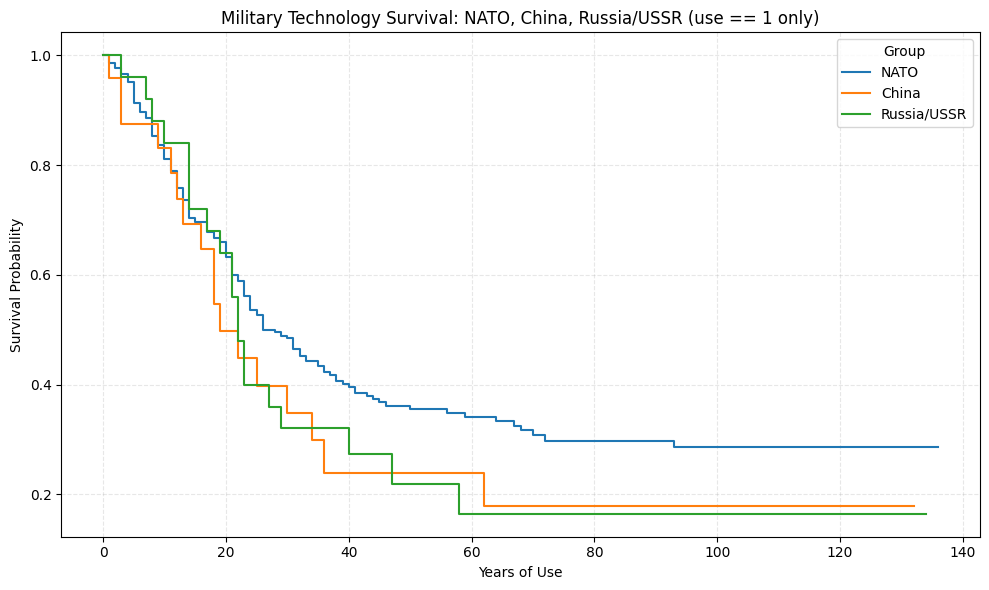

In [37]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Filter the arms_df to only include use == 1
strict_use_df = arms_df[arms_df["use"] == 1].copy()

# Detect usage spells using only active usage (use == 1)
strict_use_df = strict_use_df.sort_values(["ccode", "techname", "year"])
strict_use_df["used_shift"] = strict_use_df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
strict_use_df["new_period"] = (strict_use_df["use"] == 1) & (strict_use_df["used_shift"] != 1)
strict_use_df["usage_group"] = strict_use_df.groupby(["ccode", "techname"])["new_period"].cumsum()

# Collapse into usage spells
spells = strict_use_df.groupby(["ccode", "techname", "usage_group"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1

# Identify which technologies were still in use in 2023
active_2023 = strict_use_df[(strict_use_df["year"] == 2023) & (strict_use_df["use"] == 1)][
    ["ccode", "techname", "usage_group"]
]
active_2023["still_used_2023"] = True

# Merge and flag censoring
spells = spells.merge(active_2023, on=["ccode", "techname", "usage_group"], how="left")
spells["still_used_2023"] = spells["still_used_2023"].fillna(False)
spells["event_observed"] = (~spells["still_used_2023"]).astype(int)

# Label groups: NATO, China (ccode 710), Russia/post-USSR (e.g., ccode 365 = USSR, 364 = Russia)
nato_ccodes = [
    2, 20, 200, 220, 225, 255, 290, 310, 325, 365, 366, 368, 369, 370, 372,
    385, 402, 404, 410, 420, 421, 423, 775, 840
]
china_ccode = [710]
russia_ccodes = [365, 364]

def assign_group(ccode):
    if ccode in china_ccode:
        return "China"
    elif ccode in russia_ccodes:
        return "Russia/USSR"
    elif ccode in nato_ccodes:
        return "NATO"
    else:
        return None

spells["group"] = spells["ccode"].apply(assign_group)
grouped_spells = spells[spells["group"].notna()]

# Plot KM curves for NATO, China, and Russia
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in ["NATO", "China", "Russia/USSR"]:
    subset = grouped_spells[grouped_spells["group"] == group]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=group)
    kmf.plot_survival_function(ci_show=False)

plt.title("Military Technology Survival: NATO, China, Russia/USSR (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend(title="Group")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


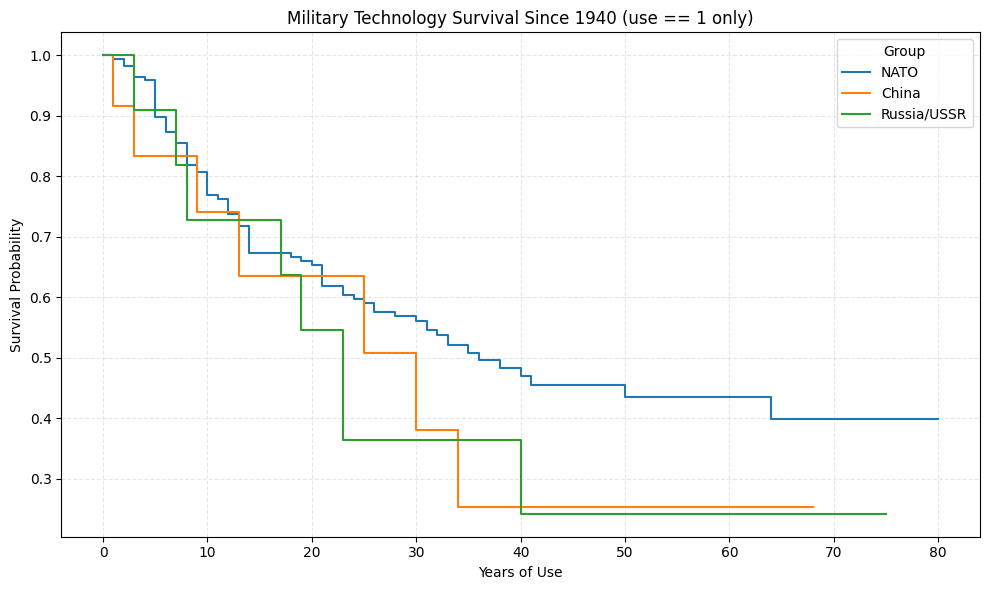

In [38]:
# Filter spells to only include those that began in 1940 or later
modern_spells = grouped_spells[grouped_spells["start_year"] >= 1940].copy()

# Plot KM curves again for NATO, China, Russia/USSR, from 1940 to present
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in ["NATO", "China", "Russia/USSR"]:
    subset = modern_spells[modern_spells["group"] == group]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=group)
    kmf.plot_survival_function(ci_show=False)

plt.title("Military Technology Survival Since 1940 (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Group")
plt.tight_layout()
plt.show()


In [39]:
from lifelines.statistics import logrank_test

# Subset by group
nato = grouped_spells[grouped_spells["group"] == "NATO"]
china = grouped_spells[grouped_spells["group"] == "China"]
russia = grouped_spells[grouped_spells["group"] == "Russia/USSR"]

# Pairwise tests
print("NATO vs China")
print(logrank_test(nato["duration_years"], china["duration_years"],
                   event_observed_A=nato["event_observed"],
                   event_observed_B=china["event_observed"]).summary)

print("NATO vs Russia")
print(logrank_test(nato["duration_years"], russia["duration_years"],
                   event_observed_A=nato["event_observed"],
                   event_observed_B=russia["event_observed"]).summary)

print("China vs Russia")
print(logrank_test(china["duration_years"], russia["duration_years"],
                   event_observed_A=china["event_observed"],
                   event_observed_B=russia["event_observed"]).summary)


NATO vs China
   test_statistic         p  -log2(p)
0        1.648393  0.199178  2.327871
NATO vs Russia
   test_statistic         p  -log2(p)
0         1.38039  0.240035  2.058685
China vs Russia
   test_statistic         p  -log2(p)
0        0.029157  0.864417    0.2102


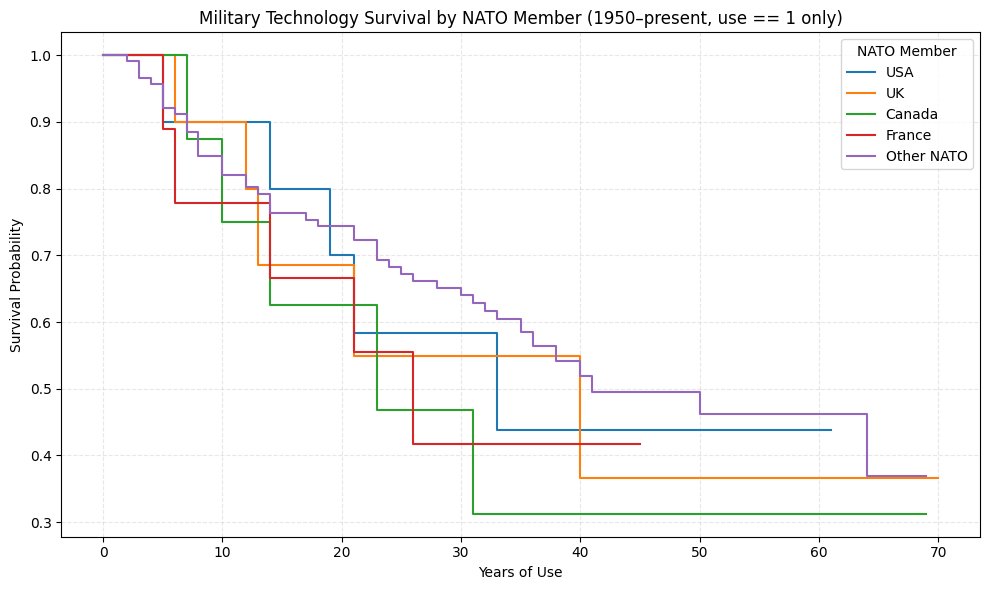

In [40]:
# Step 1: Define countries and time window
nato_ccodes = [2, 20, 200, 220, 225, 255, 290, 310, 325, 365, 366, 368, 369, 370, 372, 385, 402, 404, 410, 420, 421, 423, 775, 840]
named_nato = {
    2: "USA",
    20: "Canada",
    220: "France",
    200: "UK"
}

# Group label function
def label_nato_group(ccode):
    if ccode == 2:
        return "USA"
    elif ccode == 20:
        return "Canada"
    elif ccode == 220:
        return "France"
    elif ccode == 200:
        return "UK"
    elif ccode in nato_ccodes:
        return "Other NATO"
    else:
        return None

# Apply group labels
spells["nato_group"] = spells["ccode"].apply(label_nato_group)
nato_spells = spells[(spells["nato_group"].notna()) & (spells["start_year"] >= 1950)]

# Step 2: Plot Kaplan-Meier curves by group
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in ["USA", "UK", "Canada", "France", "Other NATO"]:
    subset = nato_spells[nato_spells["nato_group"] == group]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=group)
    kmf.plot_survival_function(ci_show=False)

plt.title("Military Technology Survival by NATO Member (1950–present, use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="NATO Member")
plt.tight_layout()
plt.show()


In [41]:
from lifelines.statistics import logrank_test

# Prepare groups
usa = nato_spells[nato_spells["nato_group"] == "USA"]
uk = nato_spells[nato_spells["nato_group"] == "UK"]
canada = nato_spells[nato_spells["nato_group"] == "Canada"]
france = nato_spells[nato_spells["nato_group"] == "France"]
other_nato = nato_spells[nato_spells["nato_group"] == "Other NATO"]

# Define test pairs
comparisons = {
    "USA vs UK": (usa, uk),
    "USA vs Canada": (usa, canada),
    "USA vs France": (usa, france),
    "USA vs Other NATO": (usa, other_nato)
}

# Run tests
for name, (a, b) in comparisons.items():
    result = logrank_test(
        a["duration_years"], b["duration_years"],
        event_observed_A=a["event_observed"],
        event_observed_B=b["event_observed"]
    )
    print(f"{name}")
    print(f"  Chi² = {result.test_statistic:.4f}, p = {result.p_value:.4f}, -log2(p) = {-np.log2(result.p_value):.2f}\n")


USA vs UK
  Chi² = 0.0410, p = 0.8395, -log2(p) = 0.25

USA vs Canada
  Chi² = 0.3486, p = 0.5549, -log2(p) = 0.85

USA vs France
  Chi² = 0.1068, p = 0.7439, -log2(p) = 0.43

USA vs Other NATO
  Chi² = 0.1283, p = 0.7202, -log2(p) = 0.47



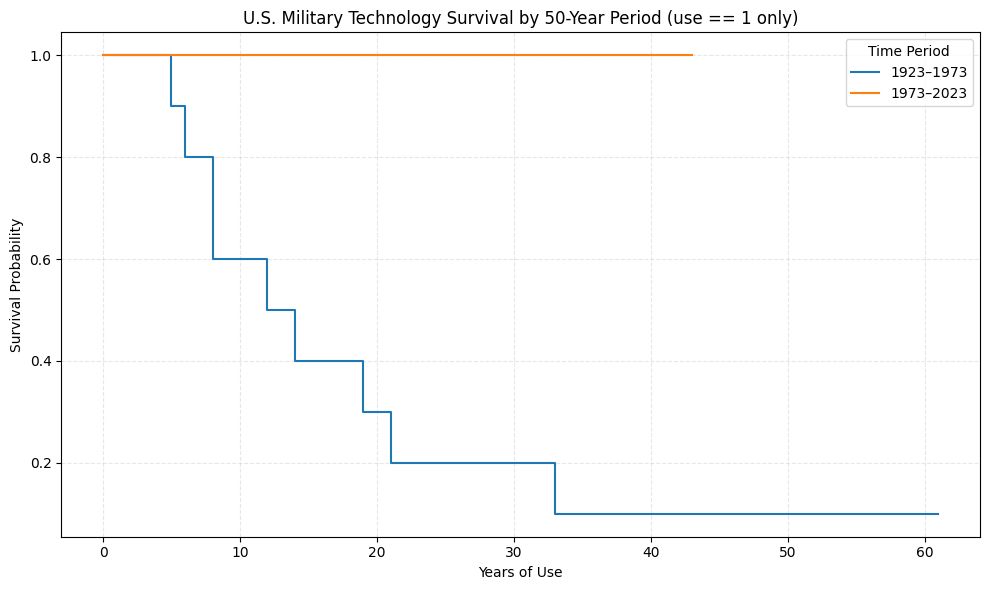

In [44]:
# Define the 50-year bins
def label_us_time_bin(row):
    if row["ccode"] != 2:
        return None
    elif 1923 <= row["start_year"] < 1973:
        return "1923–1973"
    elif 1973 <= row["start_year"] <= 2023:
        return "1973–2023"
    else:
        return None

# Apply binning to spells for USA
spells["us_bin"] = spells.apply(label_us_time_bin, axis=1)
us_binned_spells = spells[spells["us_bin"].notna()].copy()

# Plot Kaplan-Meier survival curves by 50-year bin for U.S.
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for bin_label in sorted(us_binned_spells["us_bin"].unique()):
    subset = us_binned_spells[us_binned_spells["us_bin"] == bin_label]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=bin_label)
    kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by 50-Year Period (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Time Period")
plt.tight_layout()
plt.show()


In [45]:
from lifelines.statistics import logrank_test
import itertools
import numpy as np

# Group the data by time bin
us_groups = {
    period: group for period, group in us_binned_spells.groupby("us_bin")
}

# Generate all pairwise comparisons
comparisons = list(itertools.combinations(us_groups.keys(), 2))

# Run and print results
for p1, p2 in comparisons:
    df1 = us_groups[p1]
    df2 = us_groups[p2]
    result = logrank_test(
        df1["duration_years"], df2["duration_years"],
        event_observed_A=df1["event_observed"],
        event_observed_B=df2["event_observed"]
    )
    print(f"{p1} vs {p2}")
    print(f"  Chi² = {result.test_statistic:.4f}, p = {result.p_value:.4f}, -log2(p) = {-np.log2(result.p_value):.2f}\n")


1923–1973 vs 1973–2023
  Chi² = 6.3130, p = 0.0120, -log2(p) = 6.38



In [47]:
# Filter only use==1 rows again
strict_use_df = arms_df[arms_df["use"] == 1].copy()
strict_use_df = strict_use_df.sort_values(["ccode", "techname", "year"])

# Recalculate usage groups
strict_use_df["used_shift"] = strict_use_df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
strict_use_df["new_period"] = (strict_use_df["use"] == 1) & (strict_use_df["used_shift"] != 1)
strict_use_df["usage_group"] = strict_use_df.groupby(["ccode", "techname"])["new_period"].cumsum()

# Group into spells
tech_type_spells = strict_use_df.groupby(["ccode", "techname", "techtype", "usage_group"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

# Duration
tech_type_spells["duration_years"] = tech_type_spells["end_year"] - tech_type_spells["start_year"] + 1

# Censoring based on 2023 use
active_2023 = strict_use_df[(strict_use_df["year"] == 2023) & (strict_use_df["use"] == 1)][
    ["ccode", "techname", "usage_group"]
]
active_2023["still_used_2023"] = True
tech_type_spells = tech_type_spells.merge(active_2023, on=["ccode", "techname", "usage_group"], how="left")
tech_type_spells["still_used_2023"] = tech_type_spells["still_used_2023"].fillna(False)
tech_type_spells["event_observed"] = (~tech_type_spells["still_used_2023"]).astype(int)

# Display prepared dataset for KM analysis by tech type



<ipython-input-47-04df3327e4c9>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tech_type_spells["still_used_2023"] = tech_type_spells["still_used_2023"].fillna(False)


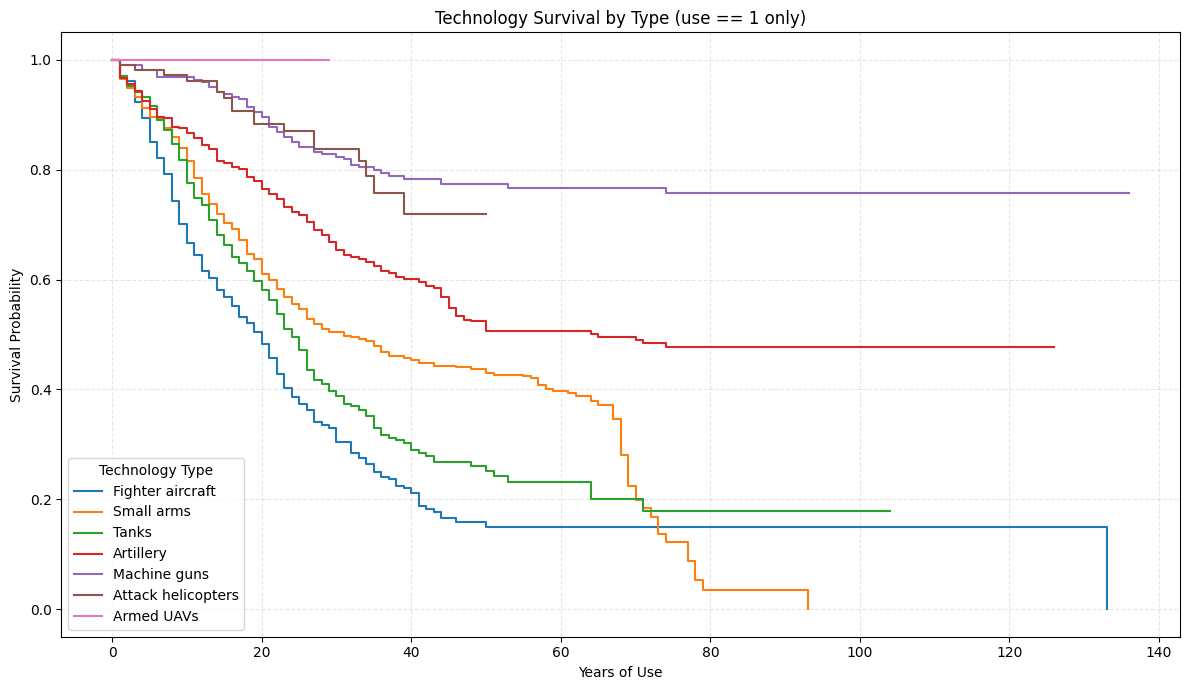

In [48]:
# Plot Kaplan-Meier survival curves by techtype (for all countries)
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

# Choose top N most frequent tech types to avoid clutter
top_techtypes = tech_type_spells["techtype"].value_counts().head(8).index

for techtype in top_techtypes:
    subset = tech_type_spells[tech_type_spells["techtype"] == techtype]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=techtype)
    kmf.plot_survival_function(ci_show=False)

plt.title("Technology Survival by Type (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Technology Type")
plt.tight_layout()
plt.show()


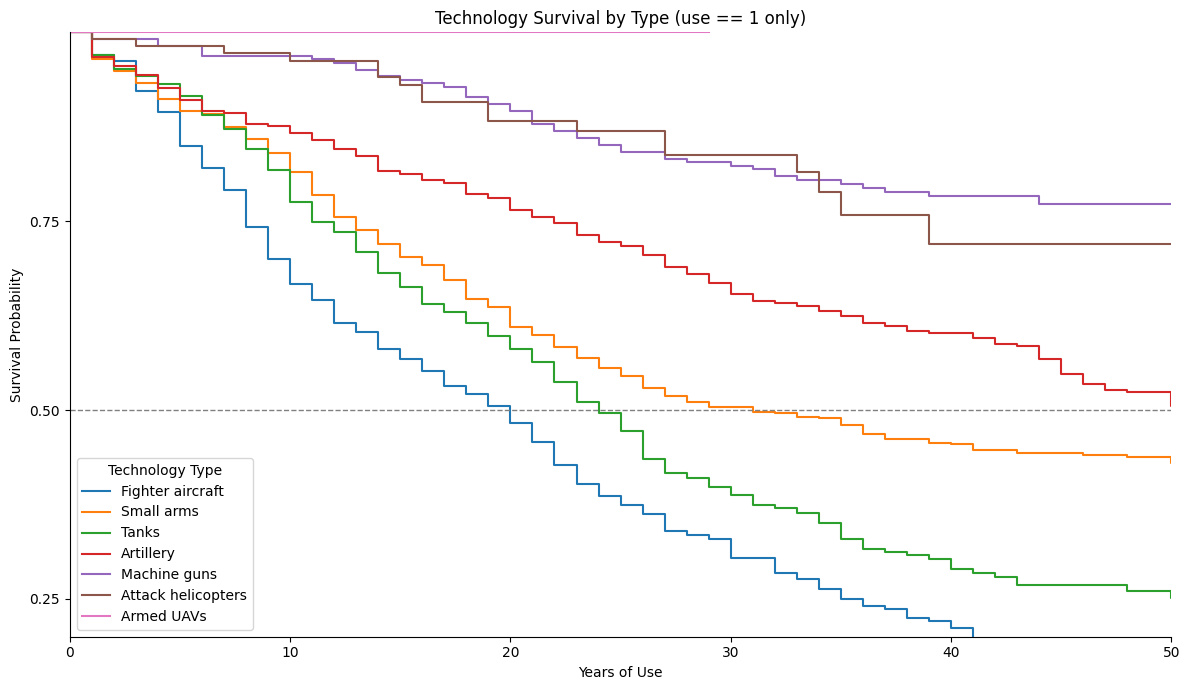

In [49]:
# Custom Kaplan-Meier plot with formatting improvements

plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

# Choose top N most frequent tech types to avoid clutter
top_techtypes = tech_type_spells["techtype"].value_counts().head(8).index

for techtype in top_techtypes:
    subset = tech_type_spells[tech_type_spells["techtype"] == techtype]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=techtype)
    kmf.plot_survival_function(ci_show=False)

# Custom formatting
plt.title("Technology Survival by Type (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.xlim(0, 50)
plt.ylim(0.2, 1.0)
plt.yticks([0.25, 0.5, 0.75])

# Horizontal line at y=0.5
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# Remove top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(title="Technology Type")
plt.tight_layout()
plt.show()


In [50]:
from lifelines.statistics import logrank_test
import itertools
import numpy as np

# Compare top 5 most common tech types pairwise
top_types = tech_type_spells["techtype"].value_counts().head(5).index
tech_groups = {
    t: df for t, df in tech_type_spells[tech_type_spells["techtype"].isin(top_types)].groupby("techtype")
}

# Pairwise comparisons
results = []
for a, b in itertools.combinations(top_types, 2):
    df1, df2 = tech_groups[a], tech_groups[b]
    result = logrank_test(
        df1["duration_years"], df2["duration_years"],
        event_observed_A=df1["event_observed"],
        event_observed_B=df2["event_observed"]
    )
    results.append((a, b, result.test_statistic, result.p_value, -np.log2(result.p_value)))

# Format results as a DataFrame
import pandas as pd
logrank_df = pd.DataFrame(results, columns=["TechType 1", "TechType 2", "Chi2", "p-value", "-log2(p)"])



In [51]:
logrank_df

,TechType 1,TechType 2,Chi2,p-value,-log2(p)
0,Fighter aircraft,Small arms,50.663761,1.096251e-12,39.730559
1,Fighter aircraft,Tanks,11.748617,6.088845e-04,10.681544
2,Fighter aircraft,Artillery,119.570386,7.855787e-28,90.040231
3,Fighter aircraft,Machine guns,199.721019,2.402769e-45,148.222066
4,Small arms,Tanks,9.767517,1.776222e-03,9.136973
5,Small arms,Artillery,33.478984,7.203820e-09,27.048591
6,Small arms,Machine guns,125.411555,4.136200e-29,94.287609
7,Tanks,Artillery,60.548280,7.179581e-15,46.985022
8,Tanks,Machine guns,140.450847,2.121412e-32,105.216675
9,Artillery,Machine guns,36.090976,1.883169e-09,28.984191


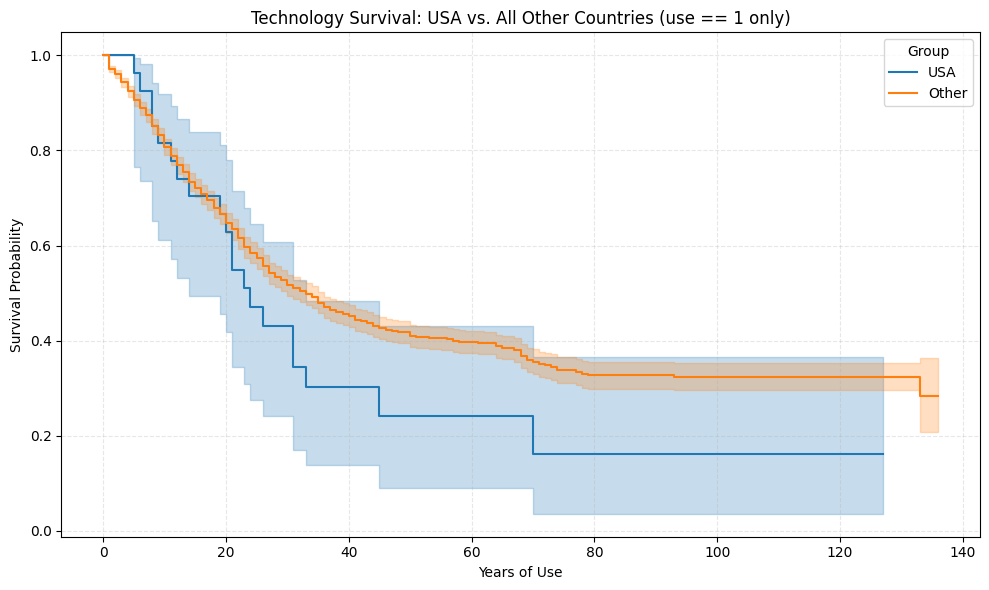

In [52]:
# Label rows as USA or Other
tech_type_spells["group"] = tech_type_spells["ccode"].apply(lambda x: "USA" if x == 2 else "Other")

# Plot Kaplan-Meier curves with confidence intervals
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in ["USA", "Other"]:
    subset = tech_type_spells[tech_type_spells["group"] == group]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Technology Survival: USA vs. All Other Countries (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Group")
plt.tight_layout()
plt.show()


In [53]:
top_types = df["techtype"].value_counts().head(5).index

plt.figure(figsize=(12, 7))
for techtype in top_types:
    subset = df[df["techtype"] == techtype]
    kmf.fit(subset["duration_years"], subset["event_observed"], label=techtype)
    kmf.plot_survival_function(ci_show=False)

plt.title("Survival by Technology Type")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'duration_years'

<Figure size 1200x700 with 0 Axes>

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import itertools

# Load long-format data
df = pd.read_csv("cow_arms_tech_long.csv")

# Only keep rows where tech is actively used
df = df[df["use"] == 1].copy()

# Sort to detect usage spells
df = df.sort_values(["ccode", "techname", "year"])

# Detect new usage period
df["used_shift"] = df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
df["new_spell"] = (df["use"] == 1) & (df["used_shift"] != 1)

# Create spell ID
df["spell_id"] = df.groupby(["ccode", "techname"])["new_spell"].cumsum()

# Collapse to one row per spell
spells = df.groupby(["ccode", "techname", "techtype", "spell_id"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

# Duration and censoring
spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1
spells["event_observed"] = (spells["end_year"] < 2023).astype(int)

# Kaplan-Meier plot by technology type (top 5 only)
top_types = spells["techtype"].value_counts().head(5).index
plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

for tech in top_types:
    subset = spells[spells["techtype"] == tech]
    kmf.fit(subset["duration_years"], subset["event_observed"], label=tech)
    kmf.plot_survival_function(ci_show=True)

plt.title("Technology Survival by Type (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.savefig("km_techtype_top5.png")
plt.close()

# Pairwise log-rank tests
results = []
tech_groups = {
    t: df for t, df in spells[spells["techtype"].isin(top_types)].groupby("techtype")
}

for a, b in itertools.combinations(top_types, 2):
    df1, df2 = tech_groups[a], tech_groups[b]
    result = logrank_test(
        df1["duration_years"], df2["duration_years"],
        event_observed_A=df1["event_observed"],
        event_observed_B=df2["event_observed"]
    )
    results.append((a, b, result.test_statistic, result.p_value, -np.log2(result.p_value)))

# Output results
logrank_df = pd.DataFrame(results, columns=["TechType 1", "TechType 2", "Chi²", "p-value", "-log2(p)"])
logrank_df.to_csv("logrank_results_techtypes.csv", index=False)
print("Log-rank test results saved to logrank_results_techtypes.csv")


Log-rank test results saved to logrank_results_techtypes.csv


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import itertools

# Load long-format data
df = pd.read_csv("cow_arms_tech_long.csv")

# Only keep rows where tech is actively used
df = df[df["use"] == 1].copy()

# Sort to detect usage spells
df = df.sort_values(["ccode", "techname", "year"])

# Detect new usage period
df["used_shift"] = df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
df["new_spell"] = (df["use"] == 1) & (df["used_shift"] != 1)

# Create spell ID
df["spell_id"] = df.groupby(["ccode", "techname"])["new_spell"].cumsum()

# Collapse to one row per spell
spells = df.groupby(["ccode", "techname", "techtype", "spell_id"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

# Duration and censoring
spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1
spells["event_observed"] = (spells["end_year"] < 2023).astype(int)

# Kaplan-Meier plot by technology type (top 5 only)
top_types = spells["techtype"].value_counts().head(5).index
plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

for tech in top_types:
    subset = spells[spells["techtype"] == tech]
    kmf.fit(subset["duration_years"], subset["event_observed"], label=tech)
    kmf.plot_survival_function(ci_show=True)

# Customize plot
plt.title("Technology Survival by Type (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.xlim(0, 50)
plt.ylim(0.2, 1.0)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.savefig("km_techtype_top5_trimmed.png")
plt.close()

# Pairwise log-rank tests
results = []
tech_groups = {
    t: df for t, df in spells[spells["techtype"].isin(top_types)].groupby("techtype")
}

for a, b in itertools.combinations(top_types, 2):
    df1, df2 = tech_groups[a], tech_groups[b]
    result = logrank_test(
        df1["duration_years"], df2["duration_years"],
        event_observed_A=df1["event_observed"],
        event_observed_B=df2["event_observed"]
    )
    results.append((a, b, result.test_statistic, result.p_value, -np.log2(result.p_value)))

# Output results
logrank_df = pd.DataFrame(results, columns=["TechType 1", "TechType 2", "Chi²", "p-value", "-log2(p)"])
logrank_df.to_csv("logrank_results_techtypes.csv", index=False)
print("Log-rank test results saved to logrank_results_techtypes.csv")


Log-rank test results saved to logrank_results_techtypes.csv


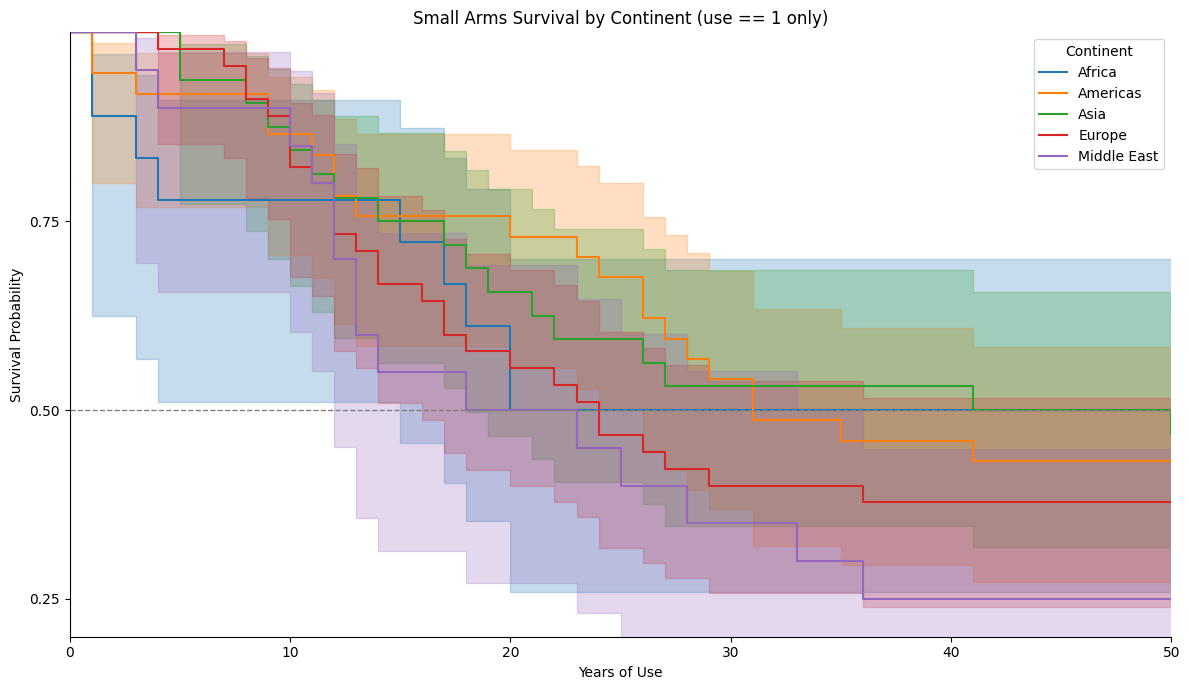

In [60]:
# Filter to only small arms usage spells
small_arms_spells = spells[spells["techtype"] == "Small arms"].copy()

# Load COW region mapping to determine continent
# For demonstration, use manual mapping of ccode to continent for the top regions
africa_codes = [437, 511, 540, 511, 432, 433, 434, 435, 436, 438, 439, 511, 511, 511, 511, 511]  # example codes
asia_codes = [630, 731, 710, 750, 740, 600, 645, 663, 690, 698, 700]
europe_codes = [200, 220, 255, 325, 365, 402, 345, 385, 390]
americas_codes = [2, 20, 100, 110, 140, 160, 165, 70, 90]
middle_east_codes = [630, 640, 645, 651, 663, 666, 670, 678, 680, 686]

def get_continent(ccode):
    if ccode in africa_codes:
        return "Africa"
    elif ccode in asia_codes:
        return "Asia"
    elif ccode in europe_codes:
        return "Europe"
    elif ccode in americas_codes:
        return "Americas"
    elif ccode in middle_east_codes:
        return "Middle East"
    else:
        return "Other"

# Apply continent label
small_arms_spells["continent"] = small_arms_spells["ccode"].apply(get_continent)

# Keep only major continents
valid_continents = ["Africa", "Asia", "Europe", "Americas", "Middle East"]
small_arms_spells = small_arms_spells[small_arms_spells["continent"].isin(valid_continents)]

# Plot KM curves by continent
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

for continent in sorted(small_arms_spells["continent"].unique()):
    subset = small_arms_spells[small_arms_spells["continent"] == continent]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=continent)
    kmf.plot_survival_function(ci_show=True)

plt.title("Small Arms Survival by Continent (use == 1 only)")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.xlim(0, 50)
plt.ylim(0.2, 1.0)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(title="Continent")
plt.tight_layout()
plt.show()


In [62]:
# Prepare the data for Cox Proportional Hazards model by including techtype as categorical
from lifelines import CoxPHFitter

# Ensure we use relevant columns and no missing values
cox_df = spells[["duration_years", "event_observed", "techname"]].dropna().copy()

# Encode techtype as dummy variables
cox_df = pd.get_dummies(cox_df, columns=["techname"], drop_first=True)

# Fit Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col="duration_years", event_col="event_observed")
cph.print_summary()


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column techname_Box magazine rifle have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_observed'].astype(bool)
>>> print(df.loc[events, 'techname_Box magazine rifle'].var())
>>> print(df.loc[~events, 'techname_Box magazine rifle'].var())

A very low variance means that the column techname_Box magazine rifle completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.956. This may imply non-unique solut

<lifelines.CoxPHFitter: fitted with 2094 total observations, 926 right-censored observations>
             duration col = 'duration_years'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 2094
number of events observed = 1168
   partial log-likelihood = -7348.01
         time fit was run = 2025-05-16 20:50:55 UTC

---
                                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                               
techname_Assault Rifle                 11.75  1.27e+05    950.09        -1850.40         1873.90                0.00                 inf
techname_Attack helicopter             14.25  1.54e+06    950.09        -1847.90         1876.40                0.00                 inf
techname_Automatic machine gun         11.86  1.41e+05    950.09        -1850.29         1874.01                0.00                 inf
techname_Box magazine rifle            15.62  6.10e+06    950.09        -1846.52         1877.77                0.00                 inf
techname_Breechloading artillery       15.86  7.72e+06    950.09        -1846.29         1878.01                0.00                 inf
techname_Breechloading rifle           16.59  1.60e+07    950.09        -1845.56         1878.74                0.00                 inf
techname_Early tank                    16.12  1.01e+07    950.09        -1846.02         1878.27                0.00                 inf
techname_Early warplane                16.13  1.01e+07    950.09        -1846.02         1878.28                0.00                 inf
techname_Field gun                     15.59  5.89e+06    950.09        -1846.56         1877.74                0.00                 inf
techname_Fifth gen. jet fighter        -0.11      0.89   2042.44        -4003.23         4003.00                0.00                 inf
techname_First gen. jet fighter        16.85  2.07e+07    950.09        -1845.30         1878.99                0.00                 inf
techname_Flintlock musket              16.16  1.04e+07    950.09        -1845.99         1878.30                0.00                 inf
techname_Fourth gen. jet fighter       13.95  1.14e+06    950.09        -1848.20         1876.10                0.00                 inf
techname_Hand-cranked machine gun      16.16  1.04e+07    950.09        -1845.99         1878.31                0.00                 inf
techname_Main battle tank (MBT)        15.49  5.36e+06    950.09        -1846.65         1877.64                0.00                 inf
techname_Minié Rifle                   17.17  2.86e+07    950.09        -1844.98         1879.32                0.00                 inf
techname_Percussion lock musket        16.67  1.74e+07    950.09        -1845.48         1878.82                0.00                 inf
techname_Recoilless artillery          11.76  1.27e+05    950.09        -1850.39         1873.90                0.00                 inf
techname_Rifled artillery              17.07  2.60e+07    950.09        -1845.07         1879.22                0.00                 inf
techname_Second gen. MBT               15.42  4.99e+06    950.09        -1846.73         1877.57                0.00                 inf
techname_Second gen. helicopter         0.08      1.08   1159.71        -2272.92         2273.08                0.00                 inf
techname_Second gen. jet fighter       17.42  3.68e+07    950.09        -1844.73         1879.57                0.00                 inf
techname_Steel tube artillery          17.27  3.18e+07    950.09        -1844.87         1879.42                0.00                 inf
techname_Third gen. MBT                13.08  4.78e+05    950.09        -1849.07         1875.23                0.00                 inf
techname_Third gen. jet fighter        15.54  5.63e+06    

In [63]:
cox_df = spells[["duration_years", "event_observed", "techtype"]].dropna().copy()
cox_df = pd.get_dummies(cox_df, columns=["techtype"], drop_first=True)

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(cox_df, duration_col="duration_years", event_col="event_observed")
cph.print_summary()


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.891. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 2094 total observations, 926 right-censored observations>
             duration col = 'duration_years'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 2094
number of events observed = 1168
   partial log-likelihood = -8105.77
         time fit was run = 2025-05-16 20:51:43 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
techtype_Artillery          13.99  1.19e+06    550.51        -1064.99         1092.97                0.00                 inf
techtype_Attack helicopters 13.29  5.91e+05    550.51        -1065.69         1092.27                0.00                 inf
techtype_Fighter aircraft   15.08  3.53e+06    550.51        -1063.90         1094.06                0.00                 inf
techtype_Machine guns       13.02  4.53e+05    550.51        -1065.96         1092.00                0.00                 inf
techtype_Small arms         14.52  2.03e+06    550.51        -1064.46         1093.50                0.00                 inf
techtype_Tanks              14.80  2.67e+06    550.51        -1064.18         1093.78                0.00                 inf

                             cmp to    z    p  -log2(p)
covariate                                              
techtype_Artillery             0.00 0.03 0.98      0.03
techtype_Attack helicopters    0.00 0.02 0.98      0.03
techtype_Fighter aircraft      0.00 0.03 0.98      0.03
techtype_Machine guns          0.00 0.02 0.98      0.03
techtype_Small arms            0.00 0.03 0.98      0.03
techtype_Tanks                 0.00 0.03 0.98      0.03
---
Concordance = 0.65
Partial AIC = 16223.54
log-likelihood ratio test = 387.38 on 6 df
-log2(p) of ll-ratio test = 265.23

In [64]:
# Filter the spells to only Small arms and Fighter aircraft
filtered_spells = spells[spells["techtype"].isin(["Small arms", "Fighter aircraft"])].copy()

# Encode techtype as a binary covariate: 1 if Fighter aircraft, 0 if Small arms
filtered_spells["is_fighter"] = (filtered_spells["techtype"] == "Fighter aircraft").astype(int)

# Prepare DataFrame for Cox model
cox_df = filtered_spells[["duration_years", "event_observed", "is_fighter"]]

# Fit Cox Proportional Hazards model
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(cox_df, duration_col="duration_years", event_col="event_observed")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 983 total observations, 306 right-censored observations>
             duration col = 'duration_years'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 983
number of events observed = 677
   partial log-likelihood = -4170.22
         time fit was run = 2025-05-16 20:52:51 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_fighter  0.56      1.75      0.08            0.40            0.71                1.49                2.04

            cmp to    z      p  -log2(p)
covariate                               
is_fighter    0.00 7.02 <0.005     38.67
---
Concordance = 0.57
Partial AIC = 8342.45
log-likelihood ratio test = 49.44 on 1 df
-log2(p) of ll-ratio test = 38.83